# GPS_Preprocess

In [1]:
import os
import glob
import pickle
from IPython.display import Markdown
from config import datapath

import pandas as pd
import numpy as np
import datetime as dt

from sklearn.cluster import DBSCAN
import statistics 

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns 
sns.set_context("notebook", rc={"axes.labelsize": 14, "xtick.labelsize": 14, "ytick.labelsize": 14})
sns.set_style("whitegrid", {'axes.grid': True})
%matplotlib inline

today = "22042024"

with open(datapath + f'/ema_data_{today}.pkl', 'rb') as file:
    df_active = pickle.load(file)

with open(datapath + f'/gps_data_{today}.pkl', 'rb') as file:
    df_gps = pickle.load(file)
    
with open(datapath + f'/passive_data_{today}.pkl', 'rb') as file:
    df_passive = pickle.load(file)

with open(datapath + f'/monitoring_data_{today}.pkl', 'rb') as file:
    df_monitoring = pickle.load(file)

## Configurations

In [2]:
min_hour_daily = 10
min_days_data = 20

#stationary filtering
max_distance = 150 
speed_limit = 1.4  # Max allowed speed in m/s

# DBSCAN
kms_per_radian = 6371.0088 # equitorial radius of the earth = 6,378.1 
epsilon = 0.05/kms_per_radian
min_samples = 50

## Prepare the dataframe

In [3]:
# Filter for participants that have finished
df_gps_merged = df_gps.merge(df_monitoring, on = "customer", how="inner")

df_gps_merged = df_gps_merged.loc[df_gps_merged.status == "Abgeschlossen"]

In [4]:
df_int = df_gps.pivot_table(
    index=["customer", "startTimestamp"],
    columns="type",
    values=["doubleValue", "startTimestamp_hour", "startTimestamp_day"],
    aggfunc='first'  # Using 'first' since each type should theoretically have only one entry per customer and timestamp
)

# Flatten the MultiIndex in columns
df_int.columns = ['_'.join(col).strip() for col in df_int.columns.values]

df_int = df_int.rename_axis(None, axis=1).reset_index()

# Drop redundant day and hour columns for longitude (assuming latitude day and hour are kept)
df_int = df_int.drop(columns=[
    'startTimestamp_day_Longitude',
    'startTimestamp_hour_Longitude'
])

# Rename the columns for clarity
df_int = df_int.rename(columns={
    'doubleValue_Latitude': 'Latitude',
    'doubleValue_Longitude': 'Longitude',
    'startTimestamp_day_Latitude': 'Day',  # Keeping one 'Day' column
    'startTimestamp_hour_Latitude': 'Hour'  # Keeping one 'Hour' column
})

df_int['weekday'] = df_int['Day'].dt.day_name()
df_int["n_hours"] = df_int.groupby(["customer", "Day"])["Hour"].transform("nunique")
df_int["n_data"] = df_int.groupby("customer")["Longitude"].transform("size")
df_int["n_data_day"] = df_int.groupby(["customer", "Day"])["Longitude"].transform("size")
df_int["n_data_hour"] = df_int.groupby(["customer", "Hour"])["Longitude"].transform("size")

df_int = df_int.loc[df_int["n_hours"] >= min_hour_daily]
df_int["n_days_8"] = df_int.groupby("customer")["Day"].transform("nunique")
df_int = df_int.loc[df_int["n_days_8"] >= min_days_data]

# Ensure your DataFrame is sorted by customer and day
df_int = df_int.sort_values(by=['customer', 'Day'])

## Descriptive Plots

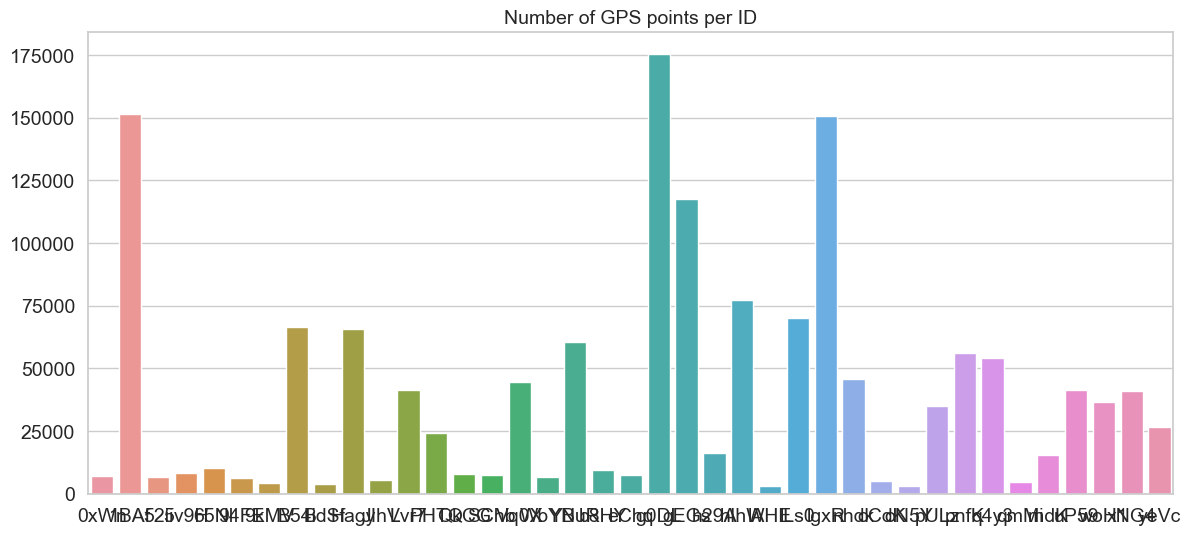

In [5]:
plt.figure(figsize=(14, 6))
sns.barplot(x='customer', y='n_data', data=df_int)
plt.title('Number of GPS points per ID',fontsize=14)
plt.ylabel('')
plt.xlabel('')

#plt.savefig("barplot_high_quality.png", dpi=300, format='png', bbox_inches='tight')
# Showing the plot
plt.show()

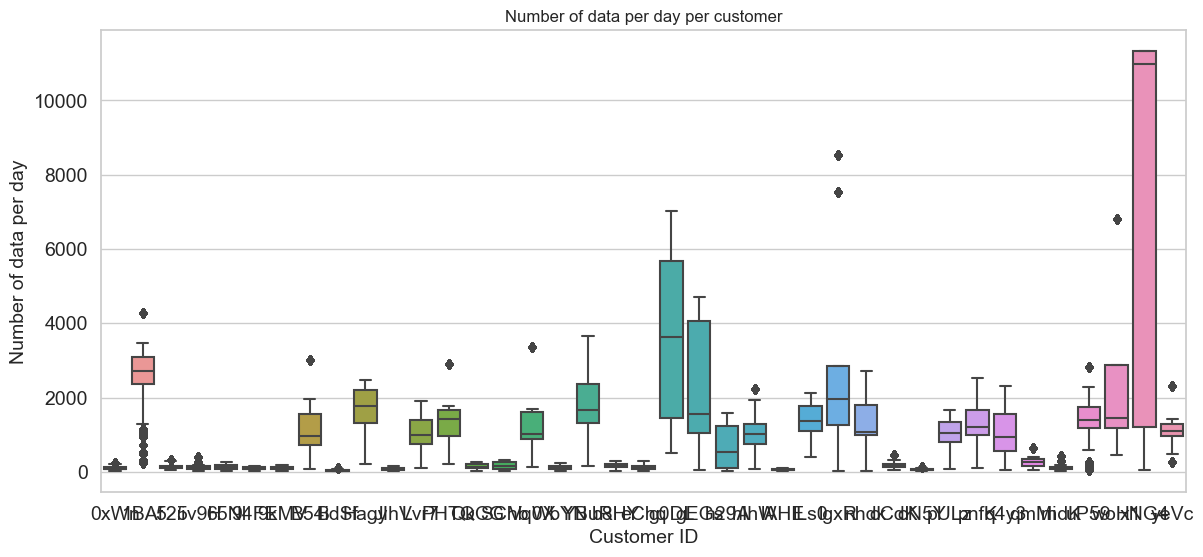

In [6]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='customer', y='n_data_day', data=df_int)
plt.title('Number of data per day per customer')
plt.ylabel('Number of data per day')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

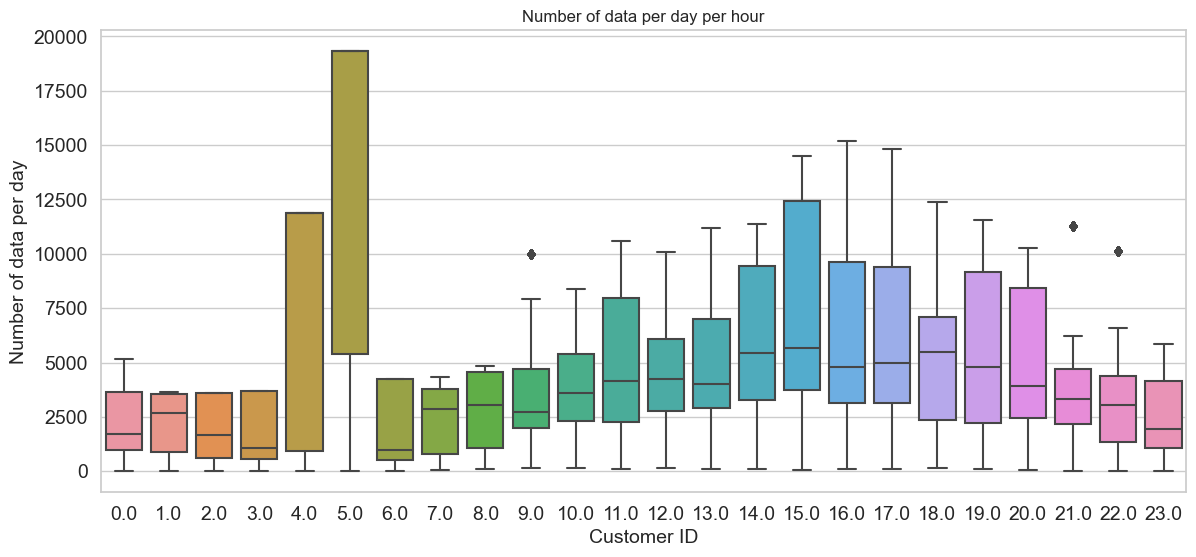

In [7]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Hour', y='n_data_hour', data=df_int)
plt.title('Number of data per day per hour')
plt.ylabel('Number of data per day')
plt.xlabel('Customer ID')

# Showing the plot
plt.show()

## Data filtering by converting GPS data to stationary data

In [8]:
# Shift the DataFrame to get previous row’s data
df_speed = df_int.copy()


In [9]:
# Haversine formula to calculate distance between two lat/lon points in meters
def haversine(lon1, lat1, lon2, lat2):
    R = 6371000  # Radius of Earth in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    meters = R * c  # Output distance in meters
    return meters

In [10]:
# Initializing columns to store calculated values
df_speed['distance'] = np.nan
df_speed['time_diff'] = np.nan
df_speed['speed'] = np.nan

# Calculating distance, time difference, and speed for each customer independently
for customer in df_speed['customer'].unique():
    mask = df_speed['customer'] == customer
    
    df_speed.loc[mask, 'distance'] = np.concatenate([
        haversine(
            df_speed.loc[mask, 'Longitude'].values[:-1], df_speed.loc[mask, 'Latitude'].values[:-1],
            df_speed.loc[mask, 'Longitude'].values[1:], df_speed.loc[mask, 'Latitude'].values[1:]
        ),
        [0]
    ])
    
    df_speed.loc[mask, 'time_diff'] = df_speed.loc[mask, 'startTimestamp'].diff().dt.total_seconds().fillna(0)
    
    # Avoid division by zero and replace NaN if time_diff is 0
    df_speed.loc[mask, 'speed'] = df_speed.loc[mask, 'distance'] / df_speed.loc[mask, 'time_diff'].replace(0, np.nan)


# Creating the stationary DataFrame
stationary_df = df_speed[(df_speed['speed'] < speed_limit) & (df_speed['distance'] < max_distance)]

In [11]:
stationary_df.n_data.describe()

count    374412.000000
mean      79479.331744
std       49972.546035
min        3017.000000
25%       41557.000000
50%       66390.000000
75%      150651.000000
max      175532.000000
Name: n_data, dtype: float64

## Prepare DBSCAN

In [12]:
# Function for clustering
def db2(x):
    clustering_model = DBSCAN(eps=epsilon, min_samples=min_samples, metric="haversine")
    cluster_labels = clustering_model.fit_predict(x[['Longitude', 'Latitude']].apply(np.radians))
    return pd.DataFrame({'cluster_100m': cluster_labels})

# Group by 'userID' and apply clustering function
geodata_cluster_df = stationary_df.groupby('customer').apply(lambda x: db2(x)).reset_index()

In [13]:
# Merge this with the main data frame
geodata_clusters = pd.concat([stationary_df.reset_index(drop=True), geodata_cluster_df['cluster_100m']], axis=1)

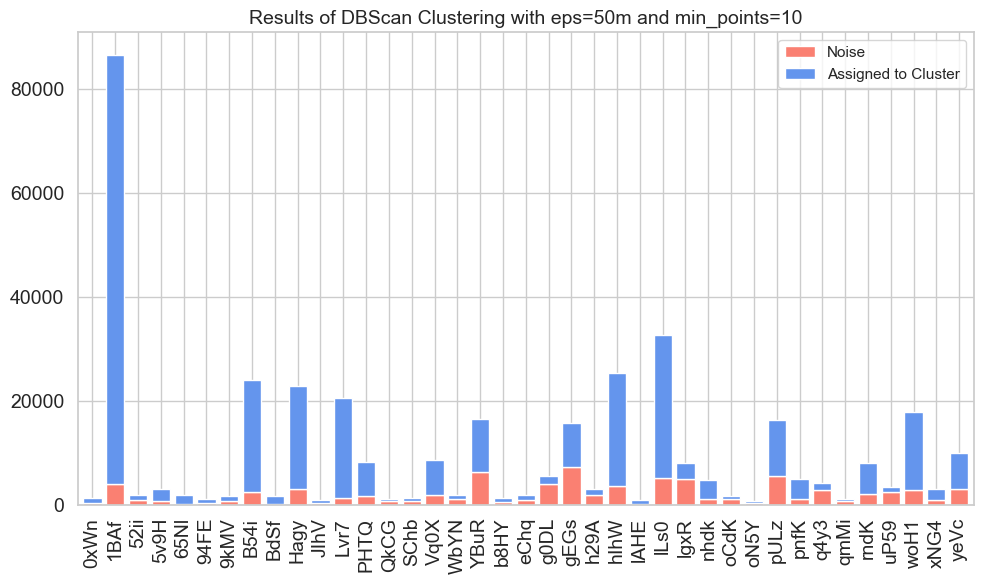

In [14]:
# Initializing a new DataFrame to store processed data
plot_data = pd.DataFrame()

# Calculating the count of "-" values per customer
plot_data['negative_count'] = geodata_clusters[geodata_clusters['cluster_100m'] == -1].groupby('customer').size()

# Calculating the count of non "-" values per customer
plot_data['positive_count'] = geodata_clusters[geodata_clusters['cluster_100m'] != -1].groupby('customer').size()

# Filling NaN with 0s (for customers with no "-" values)
plot_data = plot_data.fillna(0)

# Plotting
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10, 6), color=['salmon', 'cornflowerblue'], width=0.8)
plt.title('Results of DBScan Clustering with eps=50m and min_points=10',  fontsize=14)
plt.ylabel('')
plt.xlabel('')

# Adjusting the legend
plt.legend(["Noise", "Assigned to Cluster"], loc='upper right')

plt.savefig('dbscan_count.png', dpi=300)
# Showing the plot
plt.tight_layout()
plt.show()

In [15]:
geodata_clusters = geodata_clusters[geodata_clusters['cluster_100m'] != -1]

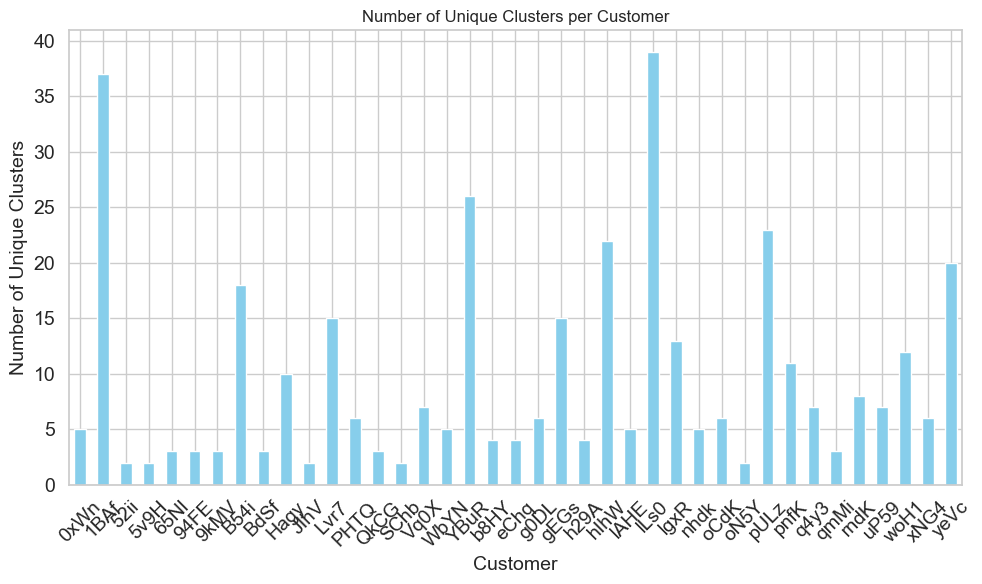

In [16]:
# Count unique clusters per customer
unique_clusters = geodata_cluster_df.groupby('customer')['cluster_100m'].nunique()
# Plotting
unique_clusters.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.xlabel('Customer')
plt.ylabel('Number of Unique Clusters')
plt.title('Number of Unique Clusters per Customer')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap, adjust as necessary
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()


In [18]:
# Generate unique IDs for clusters
geodata_clusters['clusterID'] = geodata_clusters['customer'].astype(str) + '00' + \
geodata_clusters['cluster_100m'].astype(str)

## Generate Home Location from data

In [19]:
# Filter data for night hours (midnight to 6:00 am)
geodata_night = geodata_clusters.loc[(geodata_clusters['Hour'] >= 0) & (geodata_clusters['Hour'] < 6)]

# Find the mode of clusterID per user during night hours
geodata_night = geodata_night.copy()
geodata_night['home'] = geodata_night.groupby('customer')['clusterID'].transform(lambda x: statistics.mode(x))

In [20]:
# Calculating various metrics to validate the home cluster
geodata_night['nights_with_obs'] = geodata_night.groupby('customer')['Day'].transform('nunique')
geodata_night['night_obs'] = geodata_night.groupby('customer')['Day'].transform('size')


In [21]:
# Finding the frequency of the mode
geodata_night['n_home'] = geodata_night.groupby('customer')['home'].transform(lambda x: x.value_counts().iloc[0])
geodata_night['f_home'] = geodata_night['n_home'] / geodata_night['night_obs']

# Updating the 'home' label based on conditions
geodata_night['home'] = geodata_night.apply(
    lambda x: x['home'] if x['nights_with_obs'] >= 7 and x['f_home'] > 0.5 else None, axis=1
)

# Extracting a mapping of userID to home cluster
user_home_mapping = geodata_night[['customer', 'home']].drop_duplicates()

# Merging back to the full dataset
geodata_clusters = pd.merge(geodata_clusters, user_home_mapping, on='customer', how='left')

In [22]:
# Grab relevant columns
cbusdata = geodata[['customer', 'date']]
clusterdata = geodata_clusters[['customer', 'date', 'clusterID']]

# Merge dataframes
df_int = pd.merge(df_int, clusterdata, how='left', on=['customer', 'date'])
df_int = pd.merge(df_int, cbusdata, how='left', on=['customer', 'date'])

# Order the data
df_int = df_int.sort_values(by=['customer', 'date'])


NameError: name 'geodata' is not defined